# Indian School Student Enrollment Analysis

## Background

The Unified District Information System for Education Plus ([UDISE+](https://udiseplus.gov.in/)) is an educational management information system under the Department of School Education & Literacy, Ministry of Education under the Government of India. They've published [data relating to school enrollments](https://www.data.gov.in/catalog/enrolment-age-and-class-udise-plus) for the academic years 2012-13 through 2019-20.

I wanted to go through the data to see what I could learn about student demographics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
academic_years = ('2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20')

In [3]:
def get_data(academic_year):
    return pd.read_csv(f'enrollment-data/enrollments_{academic_year}.csv')

In [4]:
enrollments = pd.concat([get_data(year) for year in academic_years], axis=0)

In [5]:
enrollments.head()

,ac_year,age,state_cd,state_name,district_cd,district_name,class_1_boys,class_2_boys,class_3_boys,class_4_boys,...,class_3_girls,class_4_girls,class_5_girls,class_6_girls,class_7_girls,class_8_girls,class_9_girls,class_10_girls,class_11_girls,class_12_girls
0,2012-13,4,1,Jammu & Kashmir,101.0,KUPWARA,1171,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012-13,4,1,Jammu & Kashmir,102.0,BARAMULA,101,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012-13,4,1,Jammu & Kashmir,103.0,SRINAGAR,140,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-13,4,1,Jammu & Kashmir,104.0,BADGAM,1826,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012-13,4,1,Jammu & Kashmir,105.0,PULWAMA,807,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
enrollments.shape

(111194, 30)

The enrollments dataset consists of a total of 111,194 entries, spanning eight academic years. Each entry has 30 columns, the first six (`ac_year`, `age`, `state_cd`, `state_name`, `district_cd`, `district_name`) of which specify the academic year, age, state, and district information at the time of enrollment. The remaining 24 columns specify the total number of students of that age, belonging to that state and district that were enrolled in that academic year.

We're going to be using the last 24 columns of the dataset containing the enrollment numbers a lot in this analysis, so let's save those column names in a single variable `class_cols`

In [7]:
class_cols = [col_name for col_name in enrollments.columns if col_name.startswith('class')]

## Cleaning

Let's first identify and take care of any apparent inconsistencies/errors in the data.

On individual exploration of the columns, I found that the state of Kerala appears twice as `Kerala` and `Kerla`. The same happens with `Orissa` and `Odisha`

In [8]:
enrollments['state_name'][enrollments.state_cd == 32].unique()

array(['Kerala', 'Kerla'], dtype=object)

In [9]:
enrollments['state_name'][enrollments.state_cd == 21].unique()

array(['Odisha', 'Orissa'], dtype=object)

The varying state names should be standardized. To this end, I'll rename all instances of `Kerla` as `Kerala`, and all instances of `Orissa` as `Odisha`.

In [10]:
enrollments.loc[enrollments.state_cd == 32, 'state_name'] = 'Kerala'
enrollments.loc[enrollments.state_cd == 21, 'state_name'] = 'Odisha'

There's also a single row in the dataset where some of the enrollment numbers are negative.

In [11]:
has_neg_enrollments = enrollments.apply(lambda row: (row[class_cols] < 0).any(), axis='columns')

In [12]:
enrollments.loc[has_neg_enrollments]

,ac_year,age,state_cd,state_name,district_cd,district_name,class_1_boys,class_2_boys,class_3_boys,class_4_boys,...,class_3_girls,class_4_girls,class_5_girls,class_6_girls,class_7_girls,class_8_girls,class_9_girls,class_10_girls,class_11_girls,class_12_girls
2680,2015-16,7,33,Tamilnadu,3308.0,SALEM,399,13161,10536,-1140,...,10594,-370,-500,0,0,0,0,0,0,0


Let's depict this row in vertical format so we can closely examine the attributes.

In [13]:
enrollments.loc[has_neg_enrollments].T

,2680
ac_year,2015-16
age,7
state_cd,33
state_name,Tamilnadu
district_cd,3308.0
district_name,SALEM
class_1_boys,399
class_2_boys,13161
class_3_boys,10536
class_4_boys,-1140


Here, the enrollment numbers for class 4 and 5 are negative. This doesn't seem to make sense, and given only a single occurence of this instances, I'll proceed with just dropping it from the dataset.

In [14]:
enrollments.drop(index=2680, inplace=True)

## Exploratory Analysis

### Total Enrollments by Year

Let's see if there is any trend in the total number of enrollments year-by-year.

In [15]:
grouped_by_academic_year = enrollments.groupby('ac_year')

In [16]:
total_enrollments_by_academic_year = grouped_by_academic_year[class_cols].sum().sum(axis=1)

In [17]:
total_enrollments_by_academic_year

ac_year
2012-13    254264553
2013-14    258502489
2014-15    259418111
2015-16    260552845
2016-17    251297067
2017-18    250960799
2018-19    248320062
2019-20    250925891
dtype: int64

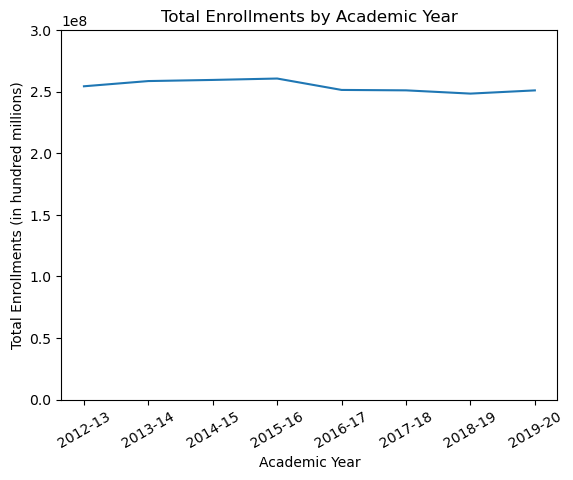

In [18]:
plt.plot(
    total_enrollments_by_academic_year.index,
    total_enrollments_by_academic_year.values
)

plt.xlabel('Academic Year')
plt.ylabel('Total Enrollments (in hundred millions)')
plt.title('Total Enrollments by Academic Year')


plt.xticks(rotation=30)
plt.ylim([0, 3e8])
plt.show()

The nationwide number of enrollments didn't change meaningfully over the six years, staying at around 250 million each year.

### Average Yearly Enrollments by School Level

Next, let's check to see what, on average, yearly enrollment numbers look like for different school levels (primary school, middle school, secondary school, sr. secondary schools).

In [19]:
primary_school_cols = [f'class_{i}_boys' for i in range(1, 6)] + [f'class_{i}_girls' for i in range(1, 6)]
middle_school_cols = [f'class_{i}_boys' for i in range(6, 9)] + [f'class_{i}_girls' for i in range(6, 9)]
secondary_school_cols = ['class_9_boys', 'class_10_boys', 'class_9_girls', 'class_10_girls']
sr_secondary_school_cols = ['class_11_boys', 'class_12_boys', 'class_11_girls', 'class_12_girls']

In [20]:
# dividing each total by 8, since the dataset records entries across eight academic years
avg_yearly_primary_school_enrollments = enrollments[primary_school_cols].sum().sum() / 8
avg_yearly_middle_school_enrollments = enrollments[middle_school_cols].sum().sum() / 8
avg_yearly_secondary_school_enrollments = enrollments[secondary_school_cols].sum().sum() / 8
avg_yearly_sr_secondary_school_enrollments = enrollments[sr_secondary_school_cols].sum().sum() / 8

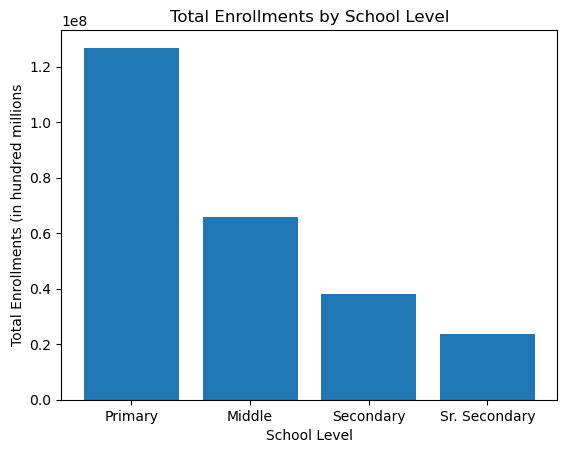

In [21]:
plt.bar(
    x=['Primary', 'Middle', 'Secondary', 'Sr. Secondary'],
    height=(
        avg_yearly_primary_school_enrollments,
        avg_yearly_middle_school_enrollments,
        avg_yearly_secondary_school_enrollments,
        avg_yearly_sr_secondary_school_enrollments
    )
)

plt.xlabel('School Level')
plt.ylabel('Total Enrollments (in hundred millions')
plt.title('Total Enrollments by School Level')

plt.show()

On average, a year sees new enrollees mostly into Primary School (classes 1-5), with Sr. Secondary School (classes 11 and 12) having the least number of new enrollees.

### Average Yearly Enrollments by State/UT

Now, let's look at what yearly enrollment numbers look like for different states and union territories.

Note that the data ranges from the academic year 2012-13 to 2019-20. During this time, a number of changes were made to state boundaries and definitions. The northwestern part of `Andhra Pradesh` became the new state of `Telangana` in 2014, and the state of `Jammu & Kashmir` was split into the union territories of `Jammu & Kashmir` and `Ladakh` in 2019.

In [22]:
grouped_by_state = enrollments.groupby('state_name')

In [23]:
# dividing by 8 since the dataset records entries across eight academic years
yearly_average_enrollments_by_state = grouped_by_state[class_cols].sum().sum(axis=1) / 8

In [24]:
sorted_enrollments = yearly_average_enrollments_by_state.sort_values(ascending=False)

In [25]:
top_three_states, remaining_states = sorted_enrollments.iloc[:3], sorted_enrollments.iloc[3:].sum()

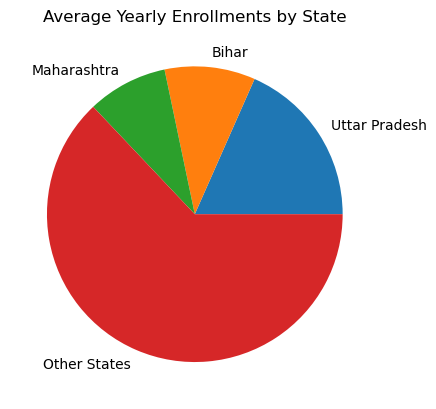

In [26]:
plt.pie(
    list(top_three_states.values) + [remaining_states],
    labels=list(top_three_states.index) + ['Other States']
)

plt.title('Average Yearly Enrollments by State')
plt.show()

In [27]:
round((top_three_states.sum() / yearly_average_enrollments_by_state.sum()) * 100, 2)

np.float64(37.06)

Uttar Pradesh, Bihar, and Maharashtra account for about 37% of yearly national enrollments, on average.

### Districts with Highest and Lowest Gender Gaps

Finally, let's see if we can identify the districts with the most and least gender disparity. To this end, we'll look at the enrollment numbers for boys and girls across all districts in the country, averaged by academic year.

In [28]:
boys_enrollment_cols = [c for c in class_cols if c.endswith('boys')]
girls_enrollment_cols = [c for c in class_cols if c.endswith('girls')]

In [29]:
grouped_by_district = enrollments.groupby(['state_name', 'district_name'])

In [30]:
# dividing by 8 since the dataset records entries across eight academic years
yearly_avg_enrollment_by_district_boys = grouped_by_district[boys_enrollment_cols].sum().sum(axis=1) / 8
yearly_avg_enrollment_by_district_girls = grouped_by_district[girls_enrollment_cols].sum().sum(axis=1) / 8

Now, we'll define a metric to measure gender gap. We measure it as a ratio of the enrollment differences between boys and girls to the total number of enrollments. In other words,

In [31]:
gender_gap_by_district = (yearly_avg_enrollment_by_district_boys - yearly_avg_enrollment_by_district_girls) / (yearly_avg_enrollment_by_district_boys + yearly_avg_enrollment_by_district_girls)

These are numbers between `-1` and `1`. The extreme value of `-1` would indicate that the disctrict saw only girls enrolled, while `1` would indicate that the district saw only boys enrolled. The values in-between then indicate how much the district enrollments swing in favor of either girls or boys.

I'm primarily interested in the absolute values here, sorted in descending order, since I want to compare districts which have the most swing to those which have the least, without regard for the direction of the swing. That is to say,

In [32]:
gender_gap_by_district.abs().sort_values(ascending=False)

state_name         district_name
Rajasthan          JAISALMER        0.179978
                   SIROHI           0.170469
Haryana            NUH              0.153728
Arunachal Pradesh  TAWANG           0.152261
Haryana            MEWAT            0.140999
                                      ...   
Tripura            NORTH TRIPURA    0.000685
Madhya Pradesh     SEONI            0.000499
Mizoram            AIZAWL           0.000316
Telangana          PEDDAPALLI       0.000107
Sikkim             SOUTH SIKKIM     0.000004
Length: 791, dtype: float64

It seems that the `Jaisalmer` district in `Rajasthan` had the highest disparity. Let's plot the enrollment numbers we calculated above for this district.

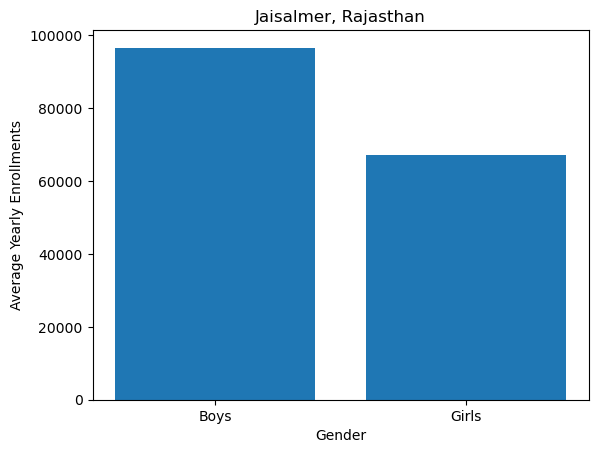

In [33]:
plt.bar(
    x=['Boys', 'Girls'],
    height=[yearly_avg_enrollment_by_district_boys.loc[:, 'JAISALMER'].iloc[0], yearly_avg_enrollment_by_district_girls.loc[:, 'JAISALMER'].iloc[0]]
)

plt.xlabel('Gender')
plt.ylabel('Average Yearly Enrollments')
plt.title('Jaisalmer, Rajasthan')

plt.show()

We observe a significant disparity here. Let's now look at the district with the least gender disparity, `South Sikkim` in `Sikkim`.

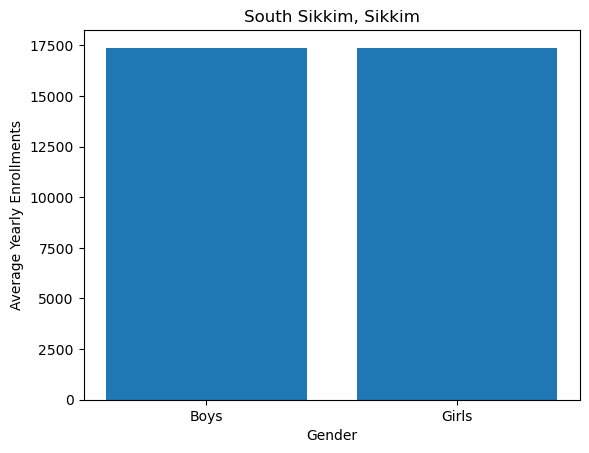

In [34]:
plt.bar(
    x=['Boys', 'Girls'],
    height=[yearly_avg_enrollment_by_district_boys.loc[:, 'SOUTH SIKKIM'].iloc[0], yearly_avg_enrollment_by_district_girls.loc[:, 'SOUTH SIKKIM'].iloc[0]]
)

plt.xlabel('Gender')
plt.ylabel('Average Yearly Enrollments')
plt.title('South Sikkim, Sikkim')

plt.show()

Almost no disparity here.